relative L1 error: 0.028735
relative L2 error: 0.033264


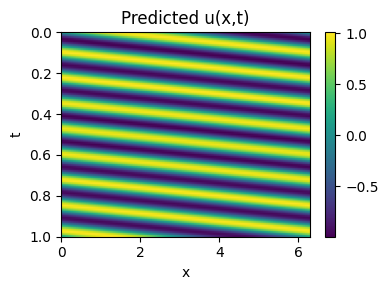

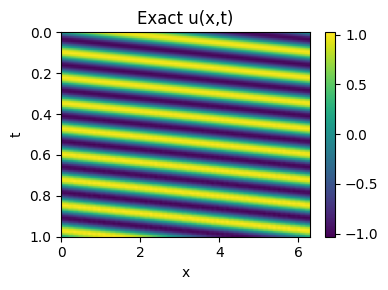

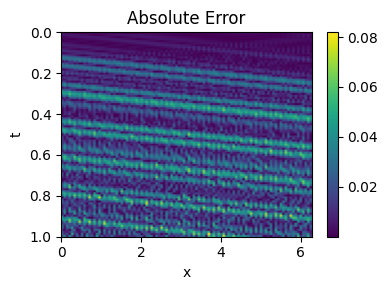

In [5]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import copy
def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] # x = 0
    b_right = data[-1,:,:] # x = 1
    b_upper = data[:,-1,:] # t = 1
    b_lower = data[:,0,:] # t = 0
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn_param=1
        for s in list(p.size()):
            nn_param = nn_param*s
        pp += nn_param
    return pp


def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import copy

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x) + self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x

class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)
    
    
class FourierFeatures(nn.Module):
    def __init__(self, in_features, mapping_size=32, init_scale=0.1):
        super(FourierFeatures, self).__init__()
        # Instead of one scalar, use a vector of scales (one per frequency band)
        self.scale = nn.Parameter(torch.ones(mapping_size) * init_scale, requires_grad=True)
        self.B = nn.Parameter(torch.randn(in_features, mapping_size), requires_grad=True)

    def forward(self, x):
        x_proj = 2 * torch.pi * x @ (self.B * self.scale)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class EnhancedEmbedding(nn.Module):
    def __init__(self, in_features, d_model, mapping_size=32, init_scale=0.1):
        super(EnhancedEmbedding, self).__init__()
        self.fourier = FourierFeatures(in_features, mapping_size, init_scale)
        # Adjust the linear layer to account for the increased dimensionality (2*mapping_size)
        self.linear = nn.Linear(2 * mapping_size, d_model)
        self.pos_emb = nn.Linear(in_features, d_model)

    def forward(self, x):
        fourier_features = self.fourier(x)
        token_emb = self.linear(fourier_features)
        pos_emb = self.pos_emb(x)
        return token_emb + pos_emb


class DecoderOnlyPINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(DecoderOnlyPINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)
        # Simple positional embedding as another linear layer.
        self.pos_emb = nn.Linear(2, d_model)

        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t):
        src = torch.cat((x, t), dim=-1)
        token_emb = self.linear_emb(src)
        pos_emb = self.pos_emb(src)
        src = token_emb + pos_emb

        d_output = self.decoder(src, src)  # decoder attends to input only
        output = self.linear_out(d_output)
        return output

class DecoderOnlyPINNsformerFourier(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads, init_scale=0.1, mapping_size=32):
        super(DecoderOnlyPINNsformerFourier, self).__init__()

        # Use the EnhancedEmbedding module which combines Fourier features and a learnable positional embedding.
        self.embedding = EnhancedEmbedding(in_features=2, d_model=d_model, mapping_size=mapping_size, init_scale=init_scale)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t):
        src = torch.cat((x, t), dim=-1)
        src = self.embedding(src)
        d_output = self.decoder(src, src)
        output = self.linear_out(d_output)
        return output
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model = DecoderOnlyPINNsformerFourier(d_out=1, d_hidden=512, d_model=32, N=1, heads=2, init_scale=0.075).to(device)
state_dict = torch.load('./PINNsformer_fourier.pt')
model.load_state_dict(state_dict)


res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]


with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

mat = scipy.io.loadmat('./convection.mat')
u = mat['u'].reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.show()
